In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

## Exercise 3 (Predator-Prey simulation) {-}

Let us first define the right hand side of the ODE as well as a function that generates realisations of the initial condition.

In [2]:
def f(u,t=0):
    u1, u2 = u[:,0], u[:,1]
        
    return np.array([u1 - u1*u2, u1*u2 - u2]).T

In [3]:
def generate_u0(ubar,delta):
    return ubar + np.random.uniform(-delta, delta, 2)

### Part (a)

Let $\hat{Q}_{h,N}$ and $\hat{\tilde Q}_{h,N}$ be given as in the exercise. Since the variance is invariant under (constant) shifts, we may w.l.o.g. assume that $\mathbb{E}[\hat{Q}_{h,N}] = \mathbb{E}[\hat{\tilde Q}_{h,N}] = 0$. With $Q_1 = \mathbb{E}[\hat{ Q}_{h,N}]$ and $Q_2 = \mathbb{E}[\hat{\tilde Q}_{h,N}]$ we then have
\begin{align*}
\mathbb{V}\left[\frac{1}{2}(Q_1 + Q_2)\right]
&=
\mathbb{E}\left[ {\left( \frac{1}{2}(Q_1 + Q_2)\right)}^{2} \right] 
-
\underbrace{\mathbb{E}\left[ {\left( \frac{1}{2}(Q_1 + Q_2)\right)} \right]^2}_{=0\text{ since $Q_1$ and $Q_2$ are centered}}
\\
&= \frac{1}{4}\left(
\mathbb{E}[Q_1^2] + \mathbb{E}[Q_2^2] + 2\mathbb{E}[Q_1 Q_2]
\right) \\
&= \frac{1}{4}(\mathbb{V}[Q_1] + \mathbb{V}[Q_2] + 2\text{Cov}(Q_1, Q_2))\,.
\end{align*}
This can now be easily approximated by the sample variances and covariances.

In [4]:
def sample_covariance(x1, x2):
    assert(len(x1) == len(x2))
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    
    cov = 0
    for i1, i2 in zip(x1,x2):
        a = i1 - m1
        b = i2 - m2
        cov += a*b/len(x1)
    return cov

In [5]:
def estimate_variance(q, qtilde):
    return 0.25*(np.var(q) + np.var(qtilde) + 2*sample_covariance(q,qtilde))

### Part (b)  {-}

The following function computes $N$ trajectories starting from initial values $u_0 \sim \text{Uni}[\Gamma]$ where $\Gamma = \bar{u}_0 + [-\delta, \delta]^2$ over the interval $[0,T]$ using `timesteps` steps for the discretization.

In [6]:
def mc_euler(u0bar, delta, T, N, timesteps, last_only = False, antithetic=False):
    h = T / timesteps
    
    if not last_only:
        trajectories = np.empty((N,timesteps,2))
    
    prev_values = np.array([generate_u0(u0bar, delta) for _ in range(N)])
    
    if antithetic:
        antithetic_values = 2*np.array(u0bar) - prev_values
        prev_values = np.vstack([prev_values, antithetic_values])
    
    if not last_only:
        trajectories[:,0,:] = prev_values
        
    for t in range(timesteps-1):
        prev_values += h*f(prev_values)
            
        if not last_only:
            trajectories[:,t+1,:] = prev_values
        
    if last_only:
        return prev_values
    else:
        return trajectories

We choose the following values (as given on the exercise sheet):

In [7]:
u0bar = [0.5,2]
delta = 0.2
T     = 6

Below we compute and plot 50 example trajectories using 200 discretization time steps.

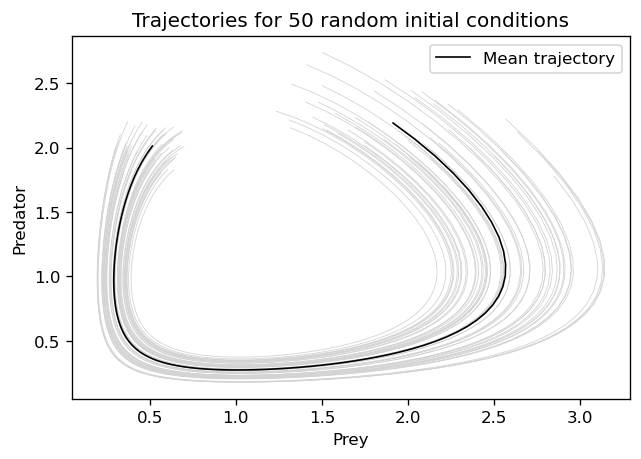

In [8]:
trajectories = mc_euler(u0bar, delta, T, 50, 100)
for trajectory in trajectories:
    plt.plot(trajectory[:,0], trajectory[:,1], "lightgray", linewidth=0.5)

mean_trajectory = np.mean(trajectories, axis=0)
plt.plot(mean_trajectory[:,0], mean_trajectory[:,1], "black", linewidth=1, label="Mean trajectory")

plt.legend()
plt.title(f"Trajectories for 50 random initial conditions")
plt.xlabel("Prey")
plt.ylabel("Predator")
plt.show();

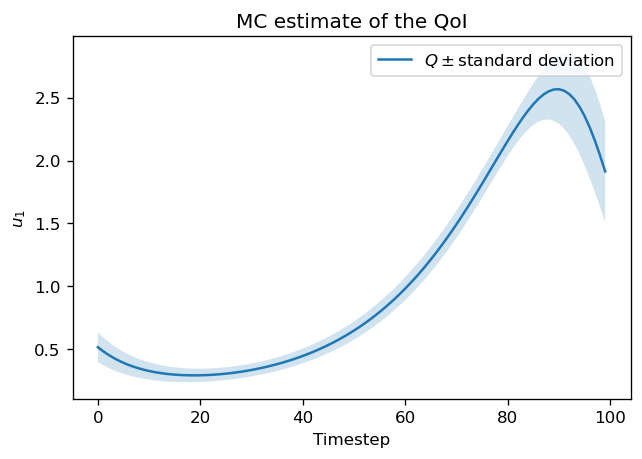

In [9]:
mc_estimate = np.mean(trajectories[:,:,0], axis=0)
mc_std = np.std(trajectories[:,:,0], axis=0)
plt.plot(mc_estimate, label="$Q \pm$standard deviation")
plt.fill_between(range(len(mc_estimate)), mc_estimate-mc_std, mc_estimate+mc_std, alpha=0.2)
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("$u_1$")
plt.title("MC estimate of the QoI")
plt.show();

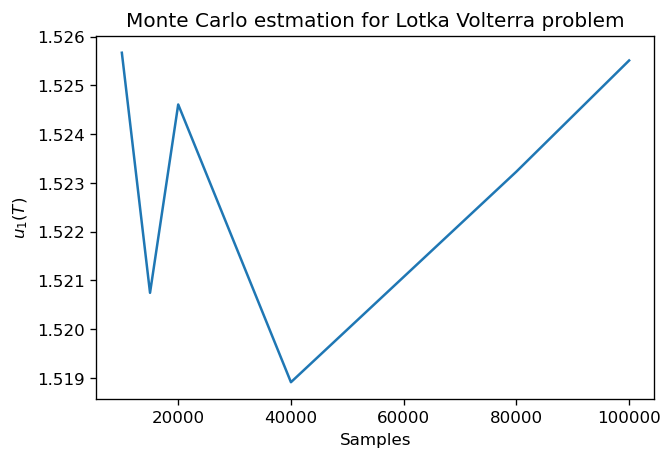

In [10]:
Ns = [10000, 15000, 20000, 40000, 80000, 100000]
results = np.empty((len(Ns)))
for i, N in enumerate(Ns):
    results[i] = np.mean(mc_euler(u0bar, delta, T, N, 1000, last_only=True)[:,0])

plt.plot(Ns, results)
plt.title("Monte Carlo estmation for Lotka Volterra problem")
plt.xlabel("Samples")
plt.ylabel("$u_1(T)$")
plt.show();

### Part (c)  {-}

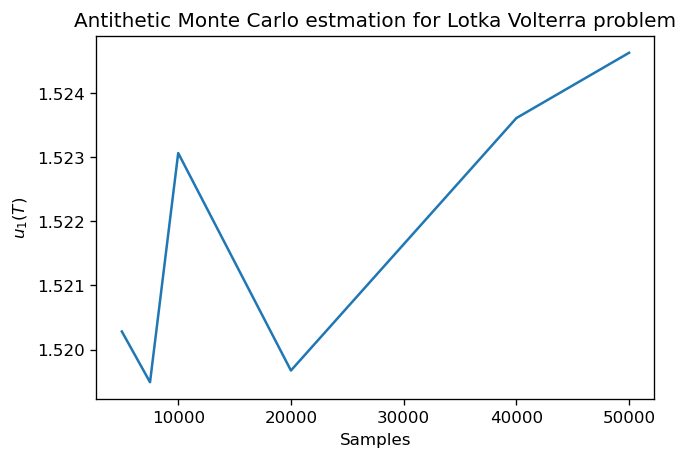

In [11]:
Ns = (0.5 * np.array(Ns)).astype(int)

results = np.empty((len(Ns)))
for i, N in enumerate(Ns):
    results[i] = np.mean(mc_euler(u0bar, delta, T, N, 1000, last_only=True)[:,0])

plt.plot(Ns, results)
plt.title("Antithetic Monte Carlo estmation for Lotka Volterra problem")
plt.xlabel("Samples")
plt.ylabel("$u_1(T)$")
plt.show();